### HW2

##  ***Main Part(4 points) Summary***
**STEPS:**

1) Capturing the traffic

2) feature Extraction

3) Constructing the dataset

4) Train-Test split

5)KNN Classification

6)KNN Classification with a different testset

**GENERAL APPROCH:** I used a bash script for capturing the requested traffic that has been generated by sending 10 requests to each website and filtered while capturing(on March 28th). Afterwards, by extracting the statistical features for both flows and reverese flows, the dataset has been created in a format of a DataFrame. Finally, by spliting the dataset into trainset (70%) and testset (30%), The classification process has been done using KNN algorithm. I used accuracy as the evaluation mertric. As the last step, the new testset has been created in the same way but through capturing the traffic genarated by sending 3 requests to each websites (on march 29th).
KNN classification has been performed with the same training set as before.

**CONCLUSION:** The performance has been dropped because of the daily change in the statistical characteristics of the traffic which is due to the daily update of the homepages of news website.

#  ***Last Part(5th point) Summary***
**GENERAL APPROCH:** I repeated the previous steps in terms of reading the captured traffic CSV files. However, the features we used is different with the previous approach as we compute the cumulative traces for each flow. After creating the dataset based on aformentioned features, we performed  the same KNN classification algorithm and evaluated its performance using accuracy metric.

**CONCLUSION:** The performance was approximately same to the previous approach.

**Note:** The results povided are based on the following zip files. They contains both csv and pacap files of the captured traffic on march 28th and march 29th:

1- captures230328.zip.zip

2-captures230329_new_test.zip




In [2]:
# Please first upload the 2 captured traffic zip files(which have been submitted with this notebook as a zip file) to the colab environment (preferably)
# Then run this cell to unzip them 

!mkdir '/content/captures230328_folder'
!mkdir '/content/captures230329_new_test_folder'

!unzip '/content/captures230328.zip.zip' -d '/content/captures230328_folder'
!unzip '/content/captures230329_new_test.zip' -d '/content/captures230329_new_test_folder'

Archive:  /content/captures230328.zip.zip
  inflating: /content/captures230328_folder/www.rt.com.pcap  
  inflating: /content/captures230328_folder/www.washingtonpost.com.pcap  
  inflating: /content/captures230328_folder/www.cnbc.com.csv  
  inflating: /content/captures230328_folder/www.cnbc.com.pcap  
  inflating: /content/captures230328_folder/www.ndtv.com.csv  
  inflating: /content/captures230328_folder/www.express.co.uk.csv  
  inflating: /content/captures230328_folder/www.bbc.co.uk.csv  
  inflating: /content/captures230328_folder/www.rt.com.csv  
  inflating: /content/captures230328_folder/www.washingtonpost.com.csv  
  inflating: /content/captures230328_folder/www.nypost.com.csv  
  inflating: /content/captures230328_folder/www.abc.net.au.pcap  
  inflating: /content/captures230328_folder/www.ndtv.com.pcap  
  inflating: /content/captures230328_folder/www.nypost.com.pcap  
  inflating: /content/captures230328_folder/www.news18.com.pcap  
  inflating: /content/captures230328_fo

# Main Part (4 points)

##1. Capturing the traffic

In [3]:
!apt-get install tshark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libc-ares2 liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpcap0.8 libsbc1
  libsmi2ldbl libspandsp2 libspeexdsp1 libwireshark-data libwireshark13
  libwiretap10 libwsutil11 wireshark-common
Suggested packages:
  mmdb-bin snmp-mibs-downloader geoipupdate geoip-database
  geoip-database-extra libjs-leaflet libjs-leaflet.markercluster wireshark-doc
The following NEW packages will be installed:
  libc-ares2 liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpcap0.8 libsbc1
  libsmi2ldbl libspandsp2 libspeexdsp1 libwireshark-data libwireshark13
  libwiretap10 libwsutil11 tshark wireshark-common
0 upgraded, 15 newly installed, 0 to remove and 23 not upgraded.
Need to get 18.2 MB of archives.
After this operation, 107 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libmaxminddb0 amd64 1.4.2-0u

In [5]:
import ipaddress
import socket

from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [6]:
hostname = socket.gethostname()
global my_private_ip
my_private_ip = socket.gethostbyname(hostname)
my_private_ip

'172.28.0.12'

In this Bash script I could capture network traffic for 10 websites chose from the provided list for homework2. I used TShark and applied a filter to eliminate traffic other than TCP or the ones exchanged between servers of same datacenters(the internal traffic of the VM).Curl command has been used to generate the traffic network towards the websites by sending 10 (and then 3) consecutive requests to each of them on March 28th (and then on March 29th). Lastly, the captured traffics have been saved as pcap and csv format in the corresponding directory.


In [ ]:
%%shell

# LIST OF WEBSITES TO VISIT
WEBSITES="https://www.washingtonpost.com https://www.ndtv.com https://www.cnbc.com https://www.timesofindia.com https://www.express.co.uk https://www.rt.com https://www.news18.com https://www.nypost.com https://www.abc.net.au https://www.bbc.co.uk"

# BPF FILTER TO APPLY, IT IGNORES ALL TRAFFIC BETWEEN SERVERS BELONGING TO THE SAME DATACENTER
# AND NON TCP TRAFFIC
FILTER="not (src net 172.16.0.0/12 && dst net 172.16.0.0/12) && tcp"

mkdir -p ./captures230329_new_test
# FOR EACH WEBSITE IN WEBSITES: START TSHARK CAPTURE IN BACKGROUND, PERFORM 10 CURLS AND KILL TSHARK
for i in $WEBSITES
do
  echo $i
  tshark -i eth0 -T fields -E header=y -E separator=, -E occurrence=f -e frame.number \
  -e frame.time -e ip.len -e ip.proto -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport \
  -e tcp.len -f "${FILTER}" -w './captures230329_new_test/'${i:8}.pcap > ./captures230329_new_test/${i:8}.csv &

  sleep 1 # TO WAIT TSHARK START
  RUNNING_PID=$!
  for j in {1..3}
  do
    echo -e "\t Req #$j"
    curl -s $i > /dev/null
    sleep 5 # wait 5 seconds between a capture and another
  done
  sleep 1 # WAIT LAST HTTP REQUEST BEFORE KILLING TSHARK CAPTURE
  kill ${RUNNING_PID}
done
exit

In [ ]:
#This cell has been used just for zip and downloading the captured traffic 
"""import shutil
import os

folder_path = "/content/captures230329_new_test"

zip_file_name = "captures230329_new_test"

shutil.make_archive(zip_file_name, 'zip', folder_path)"""


##2. Extracting biFlow features

In [7]:
def up_or_down(src_ip):
  if (ipaddress.ip_address(src_ip).is_private and src_ip != my_private_ip):
    return 'up'
  else:
    return 'down'
 #up_or_down = lambda src_ip: 'up' if (ipaddress.ip_address(src_ip).is_private and src_ip != '169.254.169.254') else 'down'



To obtain more precise statistical features, they have been computed separetly for flows and reverse flows.
Based on the source and destination IP addresses, the function first identifies the flow direction (i.e., whether it is "up" or "down") and stores the source and destination TCP ports accordingly.
Then, statistical features of flows are computed and stored in a dictionary.

Note: If a reverse flow is present (i.e., packets flowing in the opposite direction), the function repeats the same steps to compute the statistical features of the reverse flow and stores them in the flow_features dictionary with a reverse direction.

Finally, the flow_features dictionary is returned as the output of the function.






In [8]:
def extract_features(flow,df_flow, reverse_flow, df_reverse_flow):
  flow_features = {}

  # Using the flow direction store the TCP ports
  direction = up_or_down(flow[0])
  if direction == 'up':
    flow_features['dport'] = flow[3]
    flow_features['sport'] = flow[2]
  else:
    flow_features['dport'] = flow[2]
    flow_features['sport'] = flow[3]
  
  # Computing the statistical Features of input flows
  pkt_sizes = df_flow['ip.len'].astype(float)
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:]
  flow_features['num_packets '+direction] = len(df_flow)
  flow_features['total_bytes '+direction] = pkt_sizes.sum()
  flow_features['min_pkt_size '+direction] = pkt_sizes.min() 
  flow_features['max_pkt_size '+direction] = pkt_sizes.max()
  flow_features['mean_pkt_size '+direction] = pkt_sizes.mean()
  flow_features['std_pkt_size '+direction] = pkt_sizes.std()
  flow_features['min_iat '+direction] = iat.min()
  flow_features['max_iat '+direction] = iat.max()
  flow_features['mean_iat '+direction] = iat.mean()
  flow_features['std_iat '+direction] = iat.std()
  if not df_reverse_flow.empty: 
    # Computing the statistical Features of input reverse flows
    if direction == 'up':
      reverse_direction='down'
    else:
      reverse_direction='up'

    flow_features['num_packets '+reverse_direction] = len(df_reverse_flow)
    pkt_sizes = df_reverse_flow['ip.len'].astype(float)
    flow_features['total_bytes '+reverse_direction] = pkt_sizes.sum()
    flow_features['min_pkt_size '+reverse_direction] = pkt_sizes.min() 
    flow_features['max_pkt_size '+reverse_direction] = pkt_sizes.max()
    flow_features['mean_pkt_size '+reverse_direction] = pkt_sizes.mean()
    flow_features['std_pkt_size '+reverse_direction] = pkt_sizes.std()
    iat = pd.to_datetime(df_reverse_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:]
    flow_features['min_iat '+reverse_direction] = iat.min()
    flow_features['max_iat '+reverse_direction] = iat.max()
    flow_features['mean_iat '+reverse_direction] = iat.mean()
    flow_features['std_iat '+reverse_direction] = iat.std()  
  
  return flow_features

## 3. Creating the DataFrame dataset

We group the data by the source and destination IP addresses, and the TCP source and destination ports for each file by reading the CSV file as a Pandas DataFrame. The extract_features function is then called, passing in the flow data and its reverse flow data (if any), and a dictionary of features is returned.

Note: The reverse flows that have already been analyzed are tracked in the to ignore flows list so that they are not processed again. If there is a reverse flow in the dataframe when a flow is processed, its corresponding tuple is added to the "to_ignore_flows" list. By keeping track of the reverse flows that have already been processed, we ensure that each flow (and its corresponding reverse flow) is processed only once.

In [9]:
path = '/content/captures230328_folder'
files = [f for f in listdir(path) if isfile(join(path, f))]

biflow_features = pd.DataFrame()
for f in files:
  if (f.startswith('www') and f.endswith('.csv')):
    print('Processing file  ', f)
    df_tcp = pd.read_csv(join(path,f))
    df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
    to_ignore_flows = []
    for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
      if flow not in to_ignore_flows: # to ignore reverse flows that have been already analysed
        # if exists the reverse flow get its dataframe, otherwise set df_reverse_flow as an empty dataframe
        reverse_flow = (flow[1], flow[0], flow[3], flow[2])
        
        if reverse_flow in df_flows_tcp.groups: #if we have a reverse flow in the datafram, we add it to the ignore list
          df_reverse_flow = df_flows_tcp.get_group(reverse_flow)
          to_ignore_flows.append(reverse_flow)  
        else:
          df_reverse_flow = pd.DataFrame()

        flow_features = extract_features(flow, df_flow, reverse_flow, df_reverse_flow)
        flow_features['website'] = f[4:len(f)-4]
        biflow_features = biflow_features.append(flow_features,ignore_index=True)

Processing file   www.ndtv.com.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

Processing file   www.nypost.com.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

Processing file   www.timesofindia.com.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

Processing file   www.news18.com.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

Processing file   www.abc.net.au.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

Processing file   www.express.co.uk.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

Processing file   www.rt.com.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

Processing file   www.bbc.co.uk.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

Processing file   www.washingtonpost.com.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

Processing file   www.cnbc.com.csv


<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fea9ffd>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-9-40662fe

## 4. Train Test split (70% Train - 30% Test)


**Note:** Every time we execute the algorithm, we should receive the same outcome, therefore I (pseudo-randomly) fixed the train-test split's random state so that we have one way to shuffle the dataset. But, as additional work, accuracy analysis can be performed by looping through various seeds to see which will provide the highest accuracy.

In [10]:
X = biflow_features.drop(['sport','dport'],axis=1).dropna();
Y = X['website']
X = X.drop(['website'],axis=1)

# Normalization
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Split X_norm in train and test set
seed =20
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.3, shuffle=True, random_state = seed)

## 5. KNN classification and Performance Evaluation

In [13]:
# Get accuracy for each value of K in 1 to 14
ACCURACY = []
for k in range(1,15):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, Y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(Y_test, knn_predict)
  ACCURACY.append(accuracy)
  print('K =',k,'->',accuracy)



K = 1 -> 0.9666666666666667
K = 2 -> 0.9666666666666667
K = 3 -> 0.9666666666666667
K = 4 -> 0.9333333333333333
K = 5 -> 0.9333333333333333
K = 6 -> 0.9333333333333333
K = 7 -> 0.9333333333333333
K = 8 -> 0.9333333333333333
K = 9 -> 0.9333333333333333
K = 10 -> 0.9333333333333333
K = 11 -> 0.9333333333333333
K = 12 -> 0.9333333333333333
K = 13 -> 0.9333333333333333
K = 14 -> 0.9333333333333333


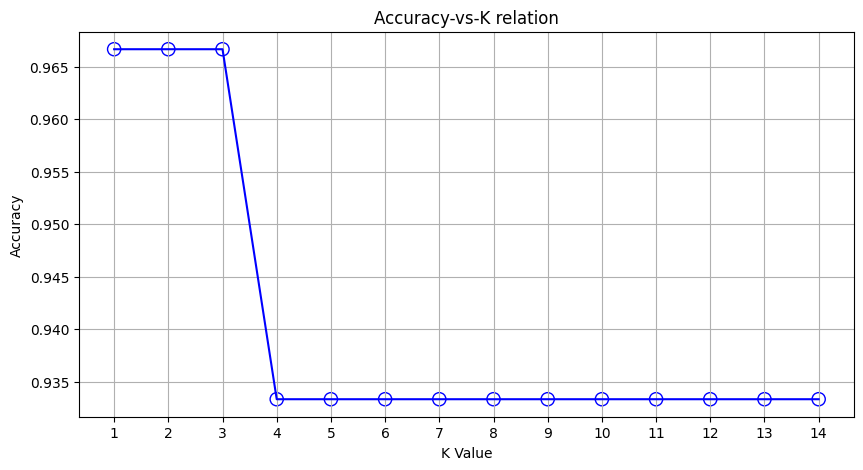

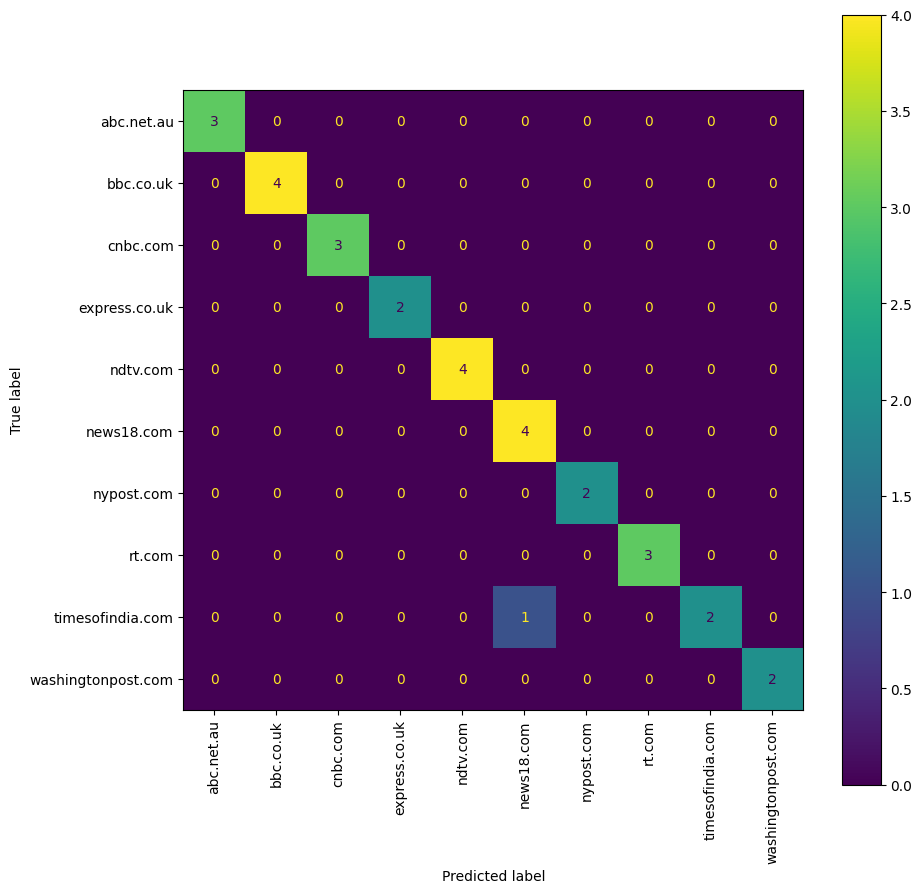

In [12]:
# Plot Accuracy over K
fig, ax = plt.subplots(figsize=(10, 5));
ax.grid(True)
ax.set_title("Accuracy-vs-K relation")
ax.set_xlabel("K Value")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(1,15))
_ = ax.plot(range(1,15), ACCURACY, 'b')
_ = ax.scatter(range(1,15), ACCURACY, s=90, facecolors='none', edgecolors='b')

#confusion matrix for best k (=1)
k = ACCURACY.index(max(ACCURACY))+1
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train, Y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(10, 10));
cm_display = ConfusionMatrixDisplay.from_predictions(knn_predict, Y_test, ax=ax);
cm_display.ax_.set_xticklabels(cm_display.ax_.get_xticklabels(), rotation=90)
plt.show()


## 6. KNN Classification and Performance evaluation with a new test set and the same training set

The steps are repeated exaclty like the previous part to extract biflow features in order to create the new testset.

In [14]:
path = '/content/captures230329_new_test_folder'
files = [f for f in listdir(path) if isfile(join(path, f))]

biflow_features_new = pd.DataFrame()
for f in files:
  if (f.startswith('www') and f.endswith('.csv')):
    print('Processing file  ', f)
    df_tcp_new = pd.read_csv(join(path,f))
    df_flows_tcp_new = df_tcp_new.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
    to_ignore_flows_new = []
    for flow_new,df_flow_new in df_flows_tcp_new: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
      if flow_new not in to_ignore_flows_new: # ignore the already analyzed reverse flows
        # if exists the reverse flow get its dataframe, otherwise set df_reverse_flow as empty dataframe
        reverse_flow_new = (flow_new[1], flow_new[0], flow_new[3], flow_new[2])
        
        if reverse_flow_new in df_flows_tcp_new.groups:
          df_reverse_flow_new = df_flows_tcp_new.get_group(reverse_flow_new)
          to_ignore_flows_new.append(reverse_flow_new)  
        else:
          df_reverse_flow_new = pd.DataFrame()

        flow_features_new = extract_features(flow_new, df_flow_new, reverse_flow_new, df_reverse_flow_new)
        flow_features_new['website'] = f[4:len(f)-4]
        biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)

Processing file   www.ndtv.com.csv
Processing file   www.nypost.com.csv
Processing file   www.timesofindia.com.csv


<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

Processing file   www.news18.com.csv


<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

Processing file   www.abc.net.au.csv
Processing file   www.express.co.uk.csv


<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

Processing file   www.rt.com.csv
Processing file   www.bbc.co.uk.csv
Processing file   www.washingtonpost.com.csv


<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

Processing file   www.cnbc.com.csv


<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-14-8e86e4211454>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

In [15]:
X_new = biflow_features_new.drop(['sport','dport'],axis=1).dropna();
Y_test_new = X_new['website']
X_new = X_new.drop(['website'],axis=1)

# Normalization
X_norm_new = scaler.fit_transform(X_new)
X_test_new = X_norm_new

In [16]:
# Get accuracy_new for each value of K in 1 to 10
ACCURACY_new = []
for k in range(1,15):
  knn_new = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn_new.fit(X_train, Y_train)
  knn_new_predict = knn_new.predict(X_test_new)
  accuracy_new = accuracy_score(Y_test_new, knn_new_predict)
  ACCURACY_new.append(accuracy_new)
  print('K =',k,'->',accuracy_new)

K = 1 -> 0.6
K = 2 -> 0.6
K = 3 -> 0.6
K = 4 -> 0.6
K = 5 -> 0.6
K = 6 -> 0.6
K = 7 -> 0.6
K = 8 -> 0.6
K = 9 -> 0.7
K = 10 -> 0.7
K = 11 -> 0.7
K = 12 -> 0.7
K = 13 -> 0.7
K = 14 -> 0.7


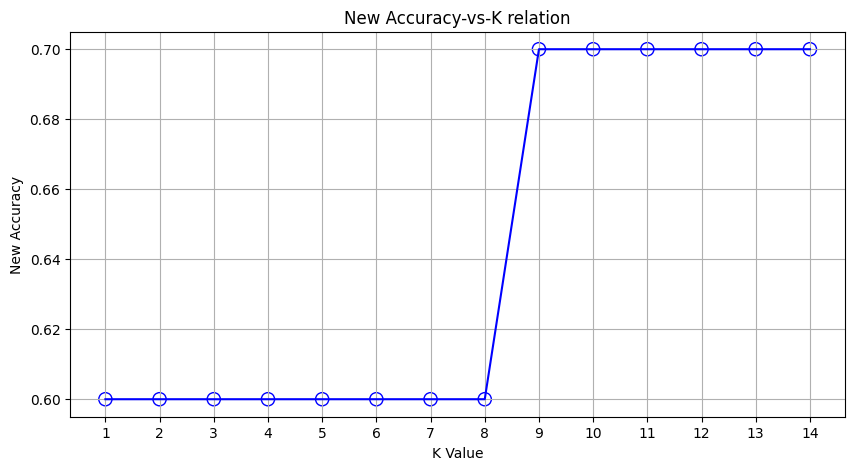

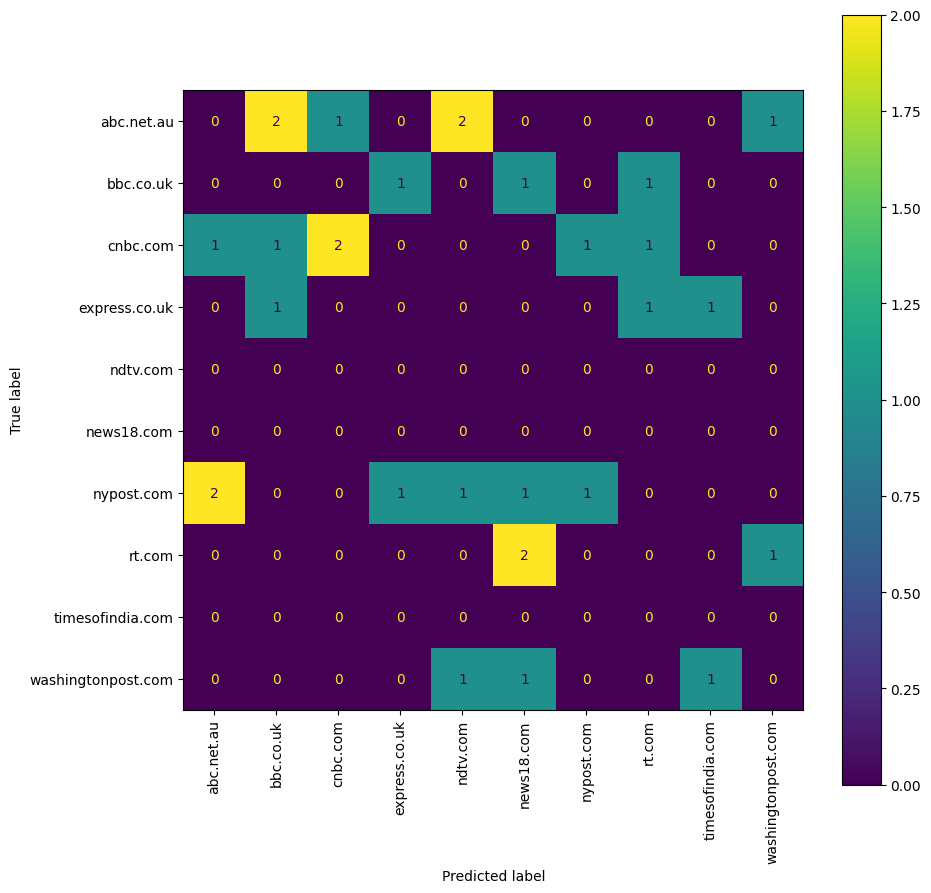

In [17]:
# Plot accuracy_new over K
fig, ax = plt.subplots(figsize=(10, 5));
ax.grid(True)
ax.set_title("New Accuracy-vs-K relation")
ax.set_xlabel("K Value")
ax.set_ylabel("New Accuracy")
ax.set_xticks(range(1,15))
_ = ax.plot(range(1,15), ACCURACY_new, 'b')
_ = ax.scatter(range(1,15), ACCURACY_new, s=90, facecolors='none', edgecolors='b')

fig, ax = plt.subplots(figsize=(10, 10));

#confusion matrix for best k (=9)
k = ACCURACY_new.index(max(ACCURACY_new))+1
knn_new = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_new.fit(X_train, Y_train)
knn_new_predict = knn_new.predict(X_test_new) 
cm_display_new = ConfusionMatrixDisplay.from_predictions(knn_new_predict, Y_test, ax=ax);
cm_display_new.ax_.set_xticklabels(cm_display_new.ax_.get_xticklabels(), rotation=90)
plt.show()

As it can be seen, the performance dropped significantly. It seems to me that since the news websites constantly change their homepage based on the upcoming news,it affect the generated traffic so that  we can not generalize KKN using features from a different day to classify the traffic of another day.

# Last part(5th Point)

## 7. Cumulative Traces

the following function computes the cumulative function of data packets in a network flow. Depending on the value of the direction parameter, I first add a new field called "downlink" to each packet in the data frames to store its direction. All packets in the df_flow dataFrame are labeled as False if the direction is "up," while all packets in the df_reverse_flow dataFrame are labeled as True. The labels are switched around if the direction is "down."

By choosing packets with non-zero values for the "tcp.len" and "ip.len" fields, the two dataFrames are joined into a single dataFrame (df_join) and TCP ACK packets filtered out.

Finally, using the 'ip.len' field of the df join data frame, the cumsum() and where() methods of Numpy are used to compute the cumulative function. The value of the packet's "ip.len" field is either added or removed from the cumulative total depending on whether it is traveling uplink or downlink. The c_func variable holds the final cumulative sum.

The cumulative function is started by inserting a zero at the beginning of the c func array, and the resulting array is returned as the function's output.


In [18]:
def get_cumulative_func(direction, df_flow, df_reverse_flow):
    # add the field 'downlink' to all packets to store its direction
    if direction == 'up':
        df_flow['downlink'] = False
        df_reverse_flow['downlink'] = True
    else:
        df_flow['downlink'] = True
        df_reverse_flow['downlink'] = False

    # combine the flow dataframes and filter out non-data TCP ACK packets
    df_join = pd.concat([df_flow, df_reverse_flow])
    df_join = df_join[(df_join['tcp.len'] > 0) & (df_join['ip.len'] > 0)]

    # compute the cumulative function using numpy cumsum and where functions
    c_func = np.cumsum(np.where(df_join['downlink'], df_join['ip.len'], -df_join['ip.len'])) 

    # prepend a zero to the cumulative function to represent the start
    c_func = np.insert(c_func, 0, 0)

    return c_func

We generate df_tcp_flow by reading csv files, just as we did before. The cumulative trace DataFrame is then created using the funcction above.

In [19]:

pd.options.mode.chained_assignment = None  # default='warn'
path = '/content/captures230328_folder'
tsharkfiles = [f for f in listdir(path) if isfile(join(path, f))]

flow_cum_traces = pd.DataFrame(columns=['c_func', 'website'])

for f in tsharkfiles:
  if (f.startswith('www') and f.endswith('.csv')):
    print('Processing file  ', f)
    df = pd.read_csv(join(path,f))
    df_tcp = df[df["ip.proto"] == 6]
    df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
    to_ignore_flows = []
    for flow,df_flow in df_flows_tcp:
      if flow not in to_ignore_flows:
        reverse_flow = (flow[1], flow[0], flow[3], flow[2])
        if reverse_flow in df_flows_tcp.groups:
          df_reverse_flow = df_flows_tcp.get_group(reverse_flow)
          to_ignore_flows.append(reverse_flow)
        else:
          df_reverse_flow = pd.DataFrame()

        c_func = get_cumulative_func(up_or_down(flow[0]), df_flow, df_reverse_flow)
        flow_cum_traces.loc[len(flow_cum_traces.index)] = [c_func, f[4:len(f)-4]]


Processing file   www.ndtv.com.csv
Processing file   www.nypost.com.csv
Processing file   www.timesofindia.com.csv
Processing file   www.news18.com.csv
Processing file   www.abc.net.au.csv
Processing file   www.express.co.uk.csv
Processing file   www.rt.com.csv
Processing file   www.bbc.co.uk.csv
Processing file   www.washingtonpost.com.csv
Processing file   www.cnbc.com.csv


In [20]:
flow_cum_traces

,c_func,website
0,"[0, 569, 701, 799, 900, 987, 1100, 1183, 1259,...",ndtv.com
1,"[0, 569, 701, 799, 900, 987, 1100, 1183, 1259,...",ndtv.com
2,"[0, 569, 701, 799, 900, 987, 1100, 1183, 1259,...",ndtv.com
3,"[0, 569, 701, 799, 900, 987, 1100, 1183, 1259,...",ndtv.com
4,"[0, 569, 701, 799, 900, 987, 1100, 1183, 1259,...",ndtv.com
...,...,...
95,"[0, 569, 701, 799, 900, 987, 1099, 1182, 1258,...",cnbc.com
96,"[0, 569, 701, 799, 900, 987, 1099, 1182, 1258,...",cnbc.com
97,"[0, 569, 701, 799, 900, 987, 1099, 1182, 1258,...",cnbc.com
98,"[0, 569, 701, 799, 900, 987, 1099, 1182, 1258,...",cnbc.com


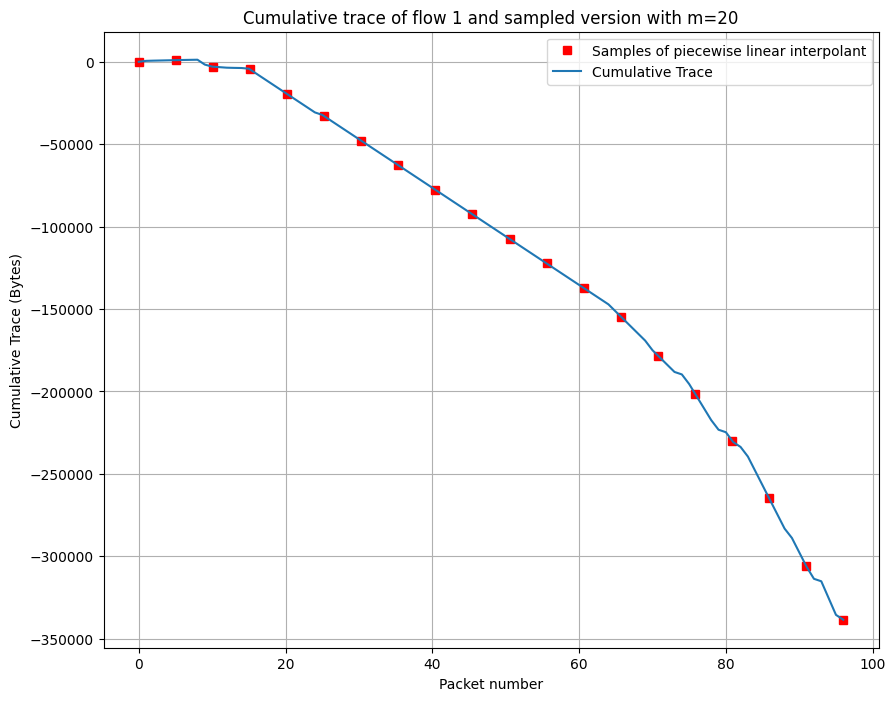

In [21]:
#visualizing the first row of the cumulative trace dataFrame

m = 20 # Number of samples of piecewise linear interpolant of the cumulative function
num_flow = 1 # flow number
start_packet = 0 # starting packet index
end_packet = 97 # ending packet index

flow_prints = flow_cum_traces.loc[num_flow].c_func[start_packet:end_packet]

x_vals = range(0, end_packet-start_packet)
x_interp = np.linspace(0, end_packet-start_packet-1, num=m)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_interp, np.interp(x_interp, x_vals, flow_prints), 'rs', label='Samples of piecewise linear interpolant')
ax.plot(x_vals, flow_prints, label='Cumulative Trace')
ax.legend()
ax.set_title('Cumulative trace of flow '+str(num_flow)+' and sampled version with m='+str(m))
ax.set_xlabel('Packet number')
ax.set_ylabel('Cumulative Trace (Bytes)')
ax.grid()

In [22]:
# Creating X_trace and Y_trace
cols = []
for i in range(0,m):
  cols.append("Sample #"+str(i))
X_trace = pd.DataFrame(columns=cols)

for idx, flow in flow_cum_traces.iterrows():
  fp = flow_cum_traces.loc[idx].c_func
  xp = range(0, len(fp))
  x = np.linspace(0, len(fp)-1, num=m)
  X_trace = X_trace.append(dict(zip(X_trace.columns, np.interp(x, xp, fp).tolist())), ignore_index=True)

Y_trace = flow_cum_traces['website']

# Normalization
scaler = StandardScaler()
X_trace_norm = scaler.fit_transform(X_trace)

#train-test split (reminder: Here, I also fixed the random state with the same seed)
X_trace_train, X_trace_test, Y_trace_train, Y_trace_test = train_test_split(X_trace_norm, Y_trace, test_size=0.3, shuffle=True, random_state=seed)


<ipython-input-22-fd99f8f1ab2a>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_trace = X_trace.append(dict(zip(X_trace.columns, np.interp(x, xp, fp).tolist())), ignore_index=True)
<ipython-input-22-fd99f8f1ab2a>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_trace = X_trace.append(dict(zip(X_trace.columns, np.interp(x, xp, fp).tolist())), ignore_index=True)
<ipython-input-22-fd99f8f1ab2a>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_trace = X_trace.append(dict(zip(X_trace.columns, np.interp(x, xp, fp).tolist())), ignore_index=True)
<ipython-input-22-fd99f8f1ab2a>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_trace

In [23]:
ACCURACY_TRACE = [] 

for k in range(1,15):
  knn_trace = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn_trace.fit(X_trace_train, Y_trace_train)
  knn_predict_trace = knn_trace.predict(X_trace_test)
  accuracy_trace = accuracy_score(Y_trace_test, knn_predict_trace)
  ACCURACY_TRACE.append(accuracy_trace)
  print('K =',k,'->',accuracy_trace)


K = 1 -> 0.9
K = 2 -> 0.9
K = 3 -> 0.9
K = 4 -> 0.9
K = 5 -> 0.9
K = 6 -> 0.9
K = 7 -> 0.9
K = 8 -> 0.9
K = 9 -> 0.9
K = 10 -> 0.9
K = 11 -> 0.9
K = 12 -> 0.9
K = 13 -> 0.9
K = 14 -> 0.9


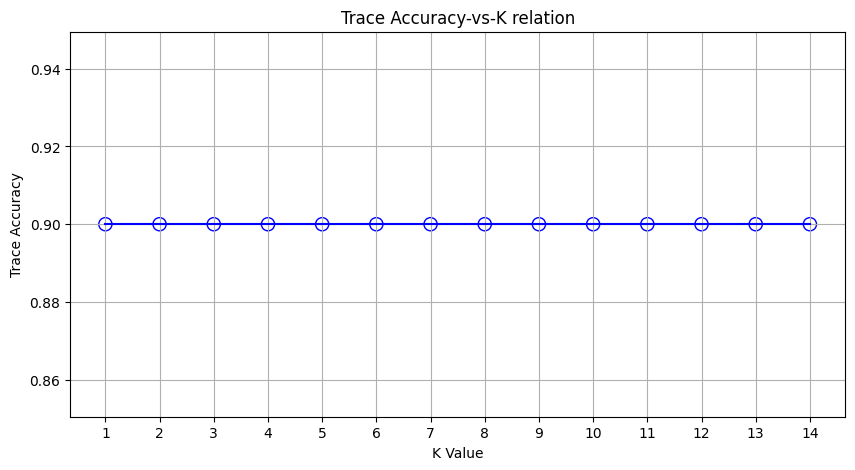

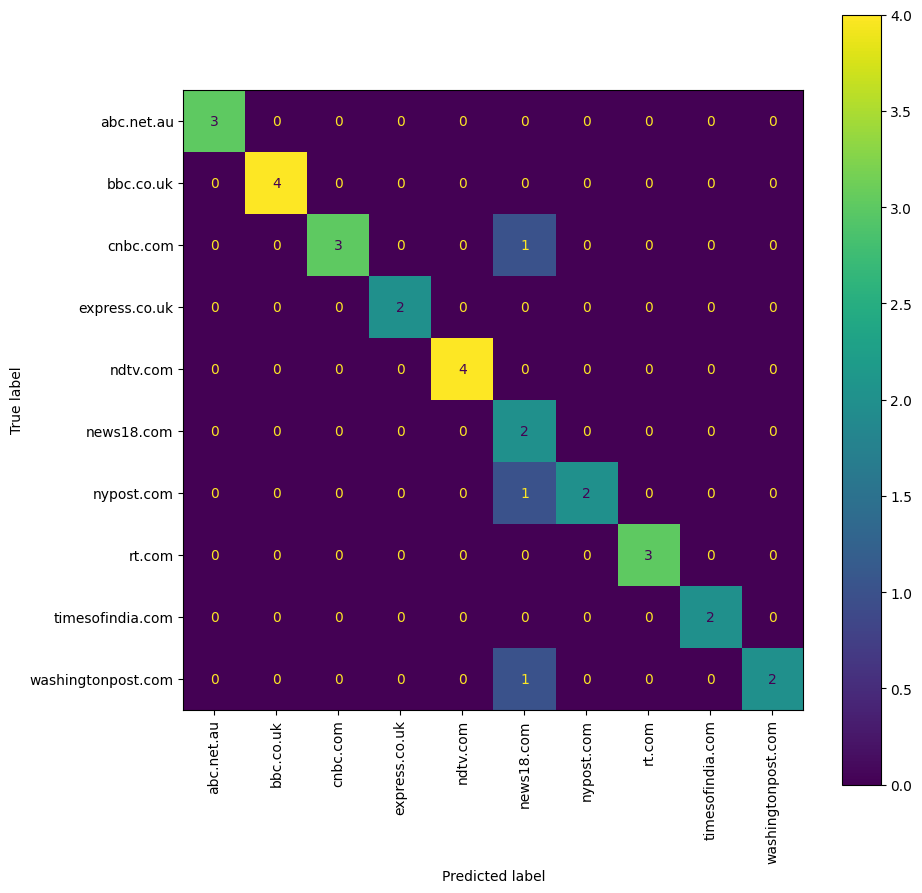

In [24]:
# Plot accuracy_new over K
fig, ax = plt.subplots(figsize=(10, 5));
ax.grid(True)
ax.set_title("Trace Accuracy-vs-K relation")
ax.set_xlabel("K Value")
ax.set_ylabel("Trace Accuracy")
ax.set_xticks(range(1,15))
_ = ax.plot(range(1,15), ACCURACY_TRACE, 'b')
_ = ax.scatter(range(1,15), ACCURACY_TRACE, s=90, facecolors='none', edgecolors='b')

fig, ax = plt.subplots(figsize=(10, 10));

#confusion matrix for best k
k = ACCURACY_TRACE.index(max(ACCURACY_TRACE))+1
knn_trace = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_trace.fit(X_trace_train, Y_trace_train)
knn_predict_trace = knn_trace.predict(X_trace_test)
cm_display_trace = ConfusionMatrixDisplay.from_predictions(knn_predict_trace, Y_trace_test, ax=ax);
cm_display_trace.ax_.set_xticklabels(cm_display_trace.ax_.get_xticklabels(), rotation=90)
plt.show()

# Performance Comparison

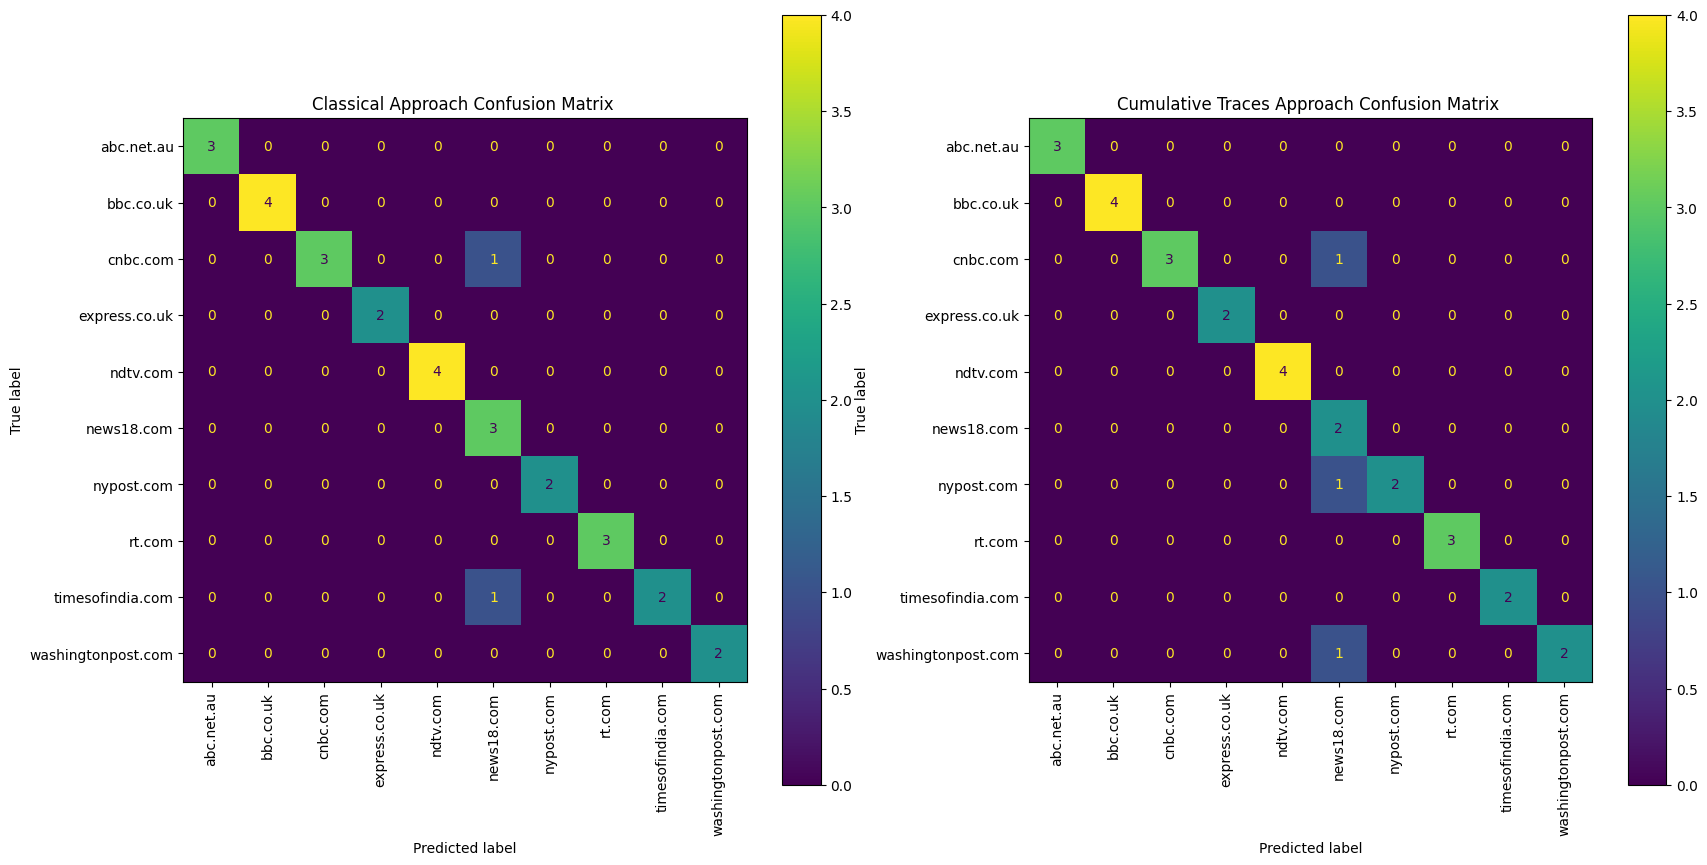

In [31]:
#Plotting Confusion matrices sid-by-side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first confusion matrix on the first subplot
cm_display = ConfusionMatrixDisplay.from_predictions(knn_predict, Y_test, ax=ax[0])
cm_display.ax_.set_xticklabels(cm_display.ax_.get_xticklabels(), rotation=90)
ax[0].set_title('Classical Approach Confusion Matrix ')

# Plot the second confusion matrix on the second subplot
cm_display_trace = ConfusionMatrixDisplay.from_predictions(knn_predict_trace, Y_trace_test, ax=ax[1])
cm_display_trace.ax_.set_xticklabels(cm_display_trace.ax_.get_xticklabels(), rotation=90)
ax[1].set_title('Cumulative Traces Approach Confusion Matrix ')

# Display the plots
plt.show()

as it can be observed, the performance outcome of both approaches are more or less the same.